In [108]:
import torch
from torchsummary import summary
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [13]:
train_csv = pd.read_csv("./sales_train.csv", parse_dates=['date'])
test_csv = pd.read_csv("./test.csv")
print(train_csv.head(5), "\n")
print(test_csv.head(5))

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-02-01               0       59    22154      999.00           1.0
1 2013-03-01               0       25     2552      899.00           1.0
2 2013-05-01               0       25     2552      899.00          -1.0
3 2013-06-01               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0 

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


In [14]:
print(train_csv.info(), "\n")
print(test_csv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None


In [15]:
print(train_csv.shape, test_csv.shape)

(2935849, 6) (214200, 3)


In [16]:
items_csv = pd.read_csv("./items.csv")
item_categories_csv = pd.read_csv("./item_categories.csv")
print(items_csv.head(5), "\n")
print(item_categories_csv.head(5))

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40   

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4


In [10]:
# if we want to use other info

# df_train = pd.merge(train_csv, items_csv, on="item_id")
# df_train = pd.merge(df_train, item_categories_csv, on="item_category_id")

# df_train.head()

In [17]:
# let's see how the items vary by date
# first, let's group by date with pandas
df_date = pd.DataFrame(train_csv.groupby('date', as_index=False)['item_price'].sum())
df_date.head(5)

,date,item_price
0,2013-01-01,1.211779e+06
1,2013-01-02,2.246770e+06
2,2013-01-03,2.330874e+06
3,2013-01-04,1.655931e+06
4,2013-01-05,2.478968e+06


In [8]:
# df_date["monthly"]= df_date["date"].apply(lambda date: date.replace(day=1))
# df_date = pd.DataFrame(df_date.groupby('monthly', as_index=False)['item_price'].sum())
# df_date.head(5)

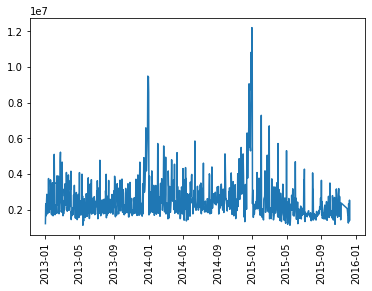

In [18]:
plt.plot( "date", "item_price", data = df_date.sort_values(by="date"))

plt.xticks(rotation=90)

plt.show()

In [38]:
train_grouped = train_csv.sort_values('date').groupby(['item_id', 'shop_id', 'date'], as_index=False)
train_grouped = train_grouped.agg({'item_cnt_day':['mean']})
train_grouped.columns = ['item_id', 'store_id', 'date', 'sales']
train_grouped['n_index'] = train_grouped[['item_id', 'store_id']].apply(tuple, axis=1)
train_grouped.head()

,item_id,store_id,date,sales,n_index
0,0,54,2014-01-09,1.0,"(0, 54)"
1,1,55,2014-02-04,1.0,"(1, 55)"
2,1,55,2014-04-04,1.0,"(1, 55)"
3,1,55,2014-04-08,1.0,"(1, 55)"
4,1,55,2014-06-07,1.0,"(1, 55)"


In [58]:
def to_time_series(data, window, to_date, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=to_date)
    cols.append(data.shift(-to_date))
    names += [('%s(t+%d)' % (col, to_date)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [87]:
window = 29
lag = 30
series = to_time_series(train_grouped.drop(['date', 'item_id', 'store_id'], axis=1), window=window, to_date=lag)
series.head()

,sales(t-29),n_index(t-29),sales(t-28),n_index(t-28),sales(t-27),n_index(t-27),sales(t-26),n_index(t-26),sales(t-25),n_index(t-25),...,sales(t-3),n_index(t-3),sales(t-2),n_index(t-2),sales(t-1),n_index(t-1),sales(t),n_index(t),sales(t+30),n_index(t+30)
29,1.0,"(0, 54)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",...,1.0,"(18, 25)",1.0,"(19, 25)",1.0,"(20, 54)",1.0,"(21, 54)",1.0,"(27, 24)"
30,1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",...,1.0,"(19, 25)",1.0,"(20, 54)",1.0,"(21, 54)",1.0,"(22, 54)",1.0,"(27, 24)"
31,1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",...,1.0,"(20, 54)",1.0,"(21, 54)",1.0,"(22, 54)",1.0,"(23, 54)",1.0,"(27, 25)"
32,1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(2, 54)",...,1.0,"(21, 54)",1.0,"(22, 54)",1.0,"(23, 54)",1.0,"(24, 54)",1.0,"(27, 25)"
33,1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(1, 55)",1.0,"(2, 54)",1.0,"(2, 54)",...,1.0,"(22, 54)",1.0,"(23, 54)",1.0,"(24, 54)",1.0,"(25, 54)",1.0,"(27, 25)"


In [88]:
shift_index = 'n_index(t-%d)' % window
series = series[series['n_index(t)'] == series[shift_index]]
series.drop(list(series.filter(regex='n_index')), axis=1, inplace=True)
series.head()


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+30)
272,1.0,2.0,2.0,3.0,4.0,1.0,1.0,5.0,1.0,2.0,...,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
273,2.0,2.0,3.0,4.0,1.0,1.0,5.0,1.0,2.0,1.0,...,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
274,2.0,3.0,4.0,1.0,1.0,5.0,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
428,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,3.0,...,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
429,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,3.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [89]:
## preparing train and test

labels_col = 'sales(t+%d)' % lag
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (307655, 30)
Validation set shape (205104, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
273206,1.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
981862,1.0,1.0,1.0,3.0,1.0,1.0,5.0,3.0,2.0,1.0,...,1.0,1.0,2.0,2.0,1.0,2.0,3.0,1.0,1.0,4.0
801763,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
947770,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2666669,3.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [90]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
Y_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
Y_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (307655, 30, 1)
Validation set shape (205104, 30, 1)


In [91]:
DatasetTrain = torch.utils.data.TensorDataset(torch.from_numpy(X_train_series),torch.from_numpy(Y_train_series))

DatasetValid= torch.utils.data.TensorDataset(torch.from_numpy(X_valid_series),torch.from_numpy(Y_valid_series))

trainloader=torch.utils.data.DataLoader(DatasetTrain,batch_size=32,shuffle=True,drop_last=True, num_workers=0)

validationloader=torch.utils.data.DataLoader(DatasetValid, batch_size=6, drop_last=True,num_workers=0)


In [140]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(X_valid_series.shape[1], 32, kernel_size=1, stride=2)
        self.conv2 = nn.Conv1d(32, X_valid_series.shape[1], kernel_size=1)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out

In [142]:
cnn = ConvNet()
print(cnn)
print(X_valid_series.shape)

summary(cnn, [30, 1])

ConvNet(
  (conv1): Conv1d(30, 32, kernel_size=(1,), stride=(2,))
  (conv2): Conv1d(32, 30, kernel_size=(1,), stride=(1,))
)
(205104, 30, 1)
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 32, 1]               992
├─Conv1d: 1-2                            [-1, 30, 1]               990
Total params: 1,982
Trainable params: 1,982
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 32, 1]               992
├─Conv1d: 1-2                            [-1, 30, 1]               990
Total params: 1,982
Trainable params: 1,982
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [127]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cnn = cnn.to(device)

cnn.train()

# input_size = 256
# hidden_size = 100
# number_classes = 10

# model = ConvNet(input_size, hidden_size, number_classes)
# model = model.to(device)
# model.train()

cpu


ConvNet(
  (conv1): Conv1d(30, 64, kernel_size=(1,), stride=(2,))
  (conv2): Conv1d(64, 30, kernel_size=(1,), stride=(1,))
)

In [102]:
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = learning_rate)
dataset_loaders = {"train": trainloader, "test": validationloader}
num_step = len(trainloader)

In [145]:
num_epochs = 50
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        for i,(x, labels) in enumerate(dataset_loaders[phase]):
            # preprocess
            x = x.to(device)
            print(x.shape)
            labels = labels.to(device)
            
            # forward pass
            y_predicted = cnn(x)
            loss = criterion(y_predicted, labels)
            
            # backward pass
            
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, num_step, loss.item()))

torch.Size([32, 30, 1])


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #3 'mat1' in call to _th_addmm_